# Introduction
The equation of motion for a particle experiencing Brownian motion in a potential $U(x)$ can be written as:

$m\ddot x = -\gamma \dot x + \sqrt{2\gamma k_B T m}\ \eta(t) - \frac{d}{dx}U(x)$

where $\gamma$ is the damping constant and $\eta(t)$ is a white noise term with mean 0 and standard deviation of 1.

Computers are generally better dealing with paired first order equations than second order equations, so we can rewrite this in a Hamiltonian formulation as:

$\dot x = v$

$\dot v = -\zeta \dot x + \sqrt{2\zeta k_B T}\ \eta(t) - \frac{d}{dx}U(x)$

where $\zeta=\gamma/m$.

This can be solved using the BAOAB integrator from [B Leimkuhler and C Matthews, *J. Chem. Phys.* (2013)]([https://aip.scitation.org/doi/abs/10.1063/1.4802990). The BAOAB integrator is a splitting method which splits the integrator into 3 steps: A, B, and O. They are applied in the order B, A, O, A, B which is where the name comes from. Since the A and B step are applied twice, they are only applied for half a timestep at a time.

The A step is the velocity update: $x(t+\Delta t/2) = x(t) + v(t)\Delta t/2$

The B step is the application of the outside potential: $v(t+\Delta t/2) = v(t) - \frac{d}{dx}U(x(t))\Delta t/2$

The O step (for Ornstein-Uhlenbeck) solves the remaining part of the velocity update. Ornstein and Uhlenbeck showed that this can be solved as: $v(t+\Delta t) = e^{-\zeta dt}v(t) + R\sqrt{k_B T/m}\sqrt{1-e^{-2 \zeta dt}}$ where $R$ is a random number drawn from a normal distribution with mean 0 and standard deviation 1. The first term represents the damping from drag and the second term represents the random kick from the environment.

This below code (adapted from the [Hocky group at NYU](http://hockygroup.hosting.nyu.edu/exercise/langevin-dynamics.html)) implements the BAOAB integrator.

### A note on numba
You might notice that the functions below have an @jit decoration above their definitions. This is to tell numba to compile these functions. Numba is a library which implements a just-in-time compiler for python. The details are a little complicate but this helps speed up code, especially code that loops through numpy arrays (like an integrator). On my computer I saw a 100x improvement in speed just by adding these decorators.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numba import jit

### Set up the potential and plot it

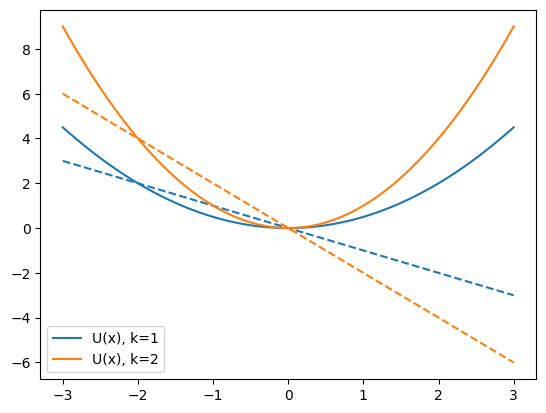

In [2]:
#this function returns the energy and force on a particle from a harmonic potential
@jit
def harmonic_oscillator_energy_force(x,k=1,x0=0):
    #calculate the energy on force on the right hand side of the equal signs
    energy = 0.5*k*(x-x0)**2
    force = -k*(x-x0)
    return energy, force

#this function will plot the energy and force
#it is very general since it uses a special python trick of taking arbitrary named arguments (**kwargs) 
#and passes them on to a specified input function
def plot_energy_force(function, xmin=-3,xmax=3,spacing=0.1,**kwargs):
    x_points = np.arange(xmin,xmax+spacing,spacing)
    energies, forces = function(x_points,**kwargs)
    label = 'U(x)'
    for arg in kwargs:
        label=label+', %s=%s'%(arg,str(kwargs[arg]))
    p = plt.plot(x_points,energies,label=label)
    plt.plot(x_points,forces,label='',color=p[0].get_color(),linestyle='--')
    plt.legend(loc=0)
    
#we can plot the energy (solid) and forces (dashed) to see if it looks right
plot_energy_force(harmonic_oscillator_energy_force,k=1)
plot_energy_force(harmonic_oscillator_energy_force,k=2)

### Set up the A, B, O steps

In [3]:
# Step A, update position from velocity
@jit
def position_update(x,v,dt):
    x_new = x + v*dt/2.
    return x_new

# Step B, update velocity with force from potential
@jit
def velocity_update(v,a,dt):
    v_new = v + a*dt/2.
    return v_new

# Step O, update velocity with damping and thermal motion
@jit
def random_velocity_update(v,gamma,kBT_m,dt):
    R = np.random.normal()
    c1 = np.exp(-gamma*dt)
    c2 = np.sqrt(1-c1*c1)*np.sqrt(kBT_m)
    v_new = c1*v + R*c2
    return v_new

### Set up the integrator

In [4]:
@jit
def baoab(potential, max_time, dt, zeta, kBT, mass, initial_position, initial_velocity,
                                        save_frequency=3, k=1, x0=0):
    x = initial_position
    v = initial_velocity
    t = 0
    step_number = 0
    save_number = 0

    times = np.linspace(0, max_time, int(max_time/dt))
    
    n_saved = int(np.ceil(times.size/save_frequency))
    save_times = np.linspace(0, max_time, n_saved)
    
    positions = np.zeros(n_saved)
    velocities = np.zeros(n_saved)
    total_energies = np.zeros(n_saved)
                             
    for t in times:
        # B
        potential_energy, force = potential(x,k,x0)
        v = velocity_update(v,force/mass,dt)
        #A
        x = position_update(x,v,dt)
        #O
        v = random_velocity_update(v,zeta,kBT/mass,dt)
        #A
        x = position_update(x,v,dt)
        # B
        potential_energy, force = potential(x,k,x0)
        v = velocity_update(v,force/mass,dt)
        
        if step_number%save_frequency == 0:
            e_total = .5*mass*v**2 + potential_energy

            positions[save_number] = x
            velocities[save_number] = v
            total_energies[save_number] = e_total
            
            save_number = save_number + 1
        
        step_number = step_number + 1
    
    return save_times, positions, velocities, total_energies   

### Define parameters

In [5]:
1.28e-5/1e-7

128.0

### Run simulation

In [6]:
def run_langevin(viscosity_factor):
    # Simulations parameters
    max_time = 8 # Simulation time, in s
    dt = 1e-7 # Timestep, in s
    save_frequency = 10 # Save every nth step
    initial_position = 0 # Starting distance of bead from trap center, in m
    initial_velocity = 0 # Starting velocity of bead, in m/s

    # Bead parameters
    # viscosity = 1e-3 # Viscosity of water at 25C, in Pa*s
    # viscosity = 0.001002 # Viscosity of water at 25C, in Pa*s
    viscosity = viscosity_factor*0.000890 # Viscosity of water at 25C, in Pa*s
    radius = 4.5e-6 # Radius of bead, in m
    density = 1050 # Density of polystyrene beads, in kg/m^3
    mass = 4/3*np.pi*radius**3*density # Mass of bead, in kg
    # gamma = 6*np.pi*viscosity*radius # Damping constant from Stoke's law, in kg/s
    gamma = 3*np.pi*viscosity*radius # Damping constant from Stoke's law, in kg/s
    zeta = gamma/mass # Damping constant, in 1/s

    # Other parameters
    k = 0.262e-3 # Trap stiffness in N/m (1 pN/nm = 1e-3 N/m)
    # k = 1e-3 # Trap stiffness in N/m (1 pN/nm = 1e-3 N/m)
    kBT = 4.11e-21 # Thermal energy at 25C, in J

    times, positions, velocities, total_energies = baoab(
        harmonic_oscillator_energy_force,
        max_time, dt, zeta, kBT, mass,
        initial_position, initial_velocity,
        save_frequency, k=k
    )
    return {"times": times, "positions": positions, "velocities": velocities, "total_energies": total_energies}

In [7]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "CMU Serif"
})


### Plot results

In [8]:
viscosity_multipliers = [2**0,2**1,2**2,2**3,2**4];

In [9]:
langevin_results = [run_langevin(T) for T in viscosity_multipliers]

/var/folders/f0/016fff6d3372w9zb168899lr0000gn/T/ipykernel_97367/3512489544.py:16: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show();


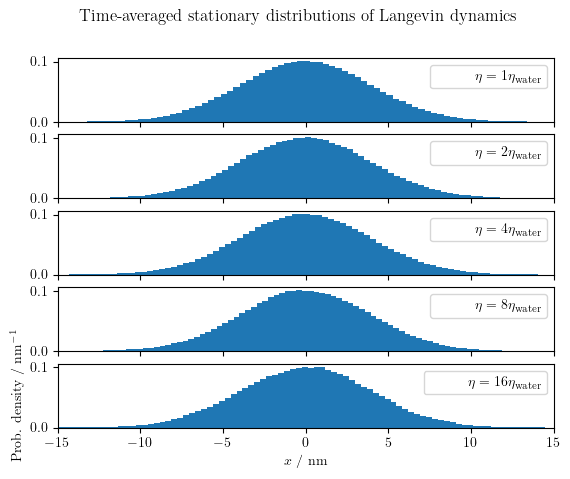

In [10]:
fig, axs = plt.subplots(5);
fig.suptitle("Time-averaged stationary distributions of Langevin dynamics");
for i in range(0,4,1):
    axs[i].hist((langevin_results[i]["positions"]-np.mean(langevin_results[i]["positions"]))/1e-9,bins=100,density=True);
    axs[i].tick_params(labelbottom=False);
    axs[i].set_xlim(-15,15);
    axs[i].plot([],[],' ',label="$\eta = "+str(viscosity_multipliers[i])+"\eta_{\mathrm{water}}$");
    axs[i].legend();
axs[4].hist((langevin_results[4]["positions"]-np.mean(langevin_results[4]["positions"]))/1e-9,bins=100,density=True);
axs[4].set_xlim(-15,15);
axs[4].plot([],[],' ',label="$\eta = "+str(viscosity_multipliers[4])+"\eta_{\mathrm{water}}$");
axs[4].legend();
axs[4].set_ylabel("Prob. density / $\mathrm{nm}^{-1}$")
axs[4].set_xlabel("$x$ / nm")
fig.savefig("Langevin_vs_viscosity_time_averaged.png",dpi=300)
fig.show();

In [11]:
plt.figure()
# plt.plot(times[0:1000],positions[0:1000],marker='',label='position',linestyle='-', color="r")
plt.plot(times,positions,marker='',label='position',linestyle='-', color="r")
plt.xlabel('Time (s)')
plt.ylabel('Position (m)')
plt.ylim(-1.25e-8,1.25e-8)
plt.xlim(0,0.01)
plt.show()

plt.figure()
plt.plot(times[0:1000],velocities[0:1000],marker='',label='velocity',linestyle='-')
plt.xlabel('Time (s)')
plt.ylabel('Velocity (m/s)')
plt.show()

plt.figure()
plt.plot(times[0:1000],total_energies[0:1000],linestyle='-',label='Instantaneuos E')
plt.axhline(np.mean(total_energies),color='r',label='Average E')
plt.xlabel('Time (s)')
plt.ylabel('Total Energy (J)')
plt.legend()
plt.show()

NameError: name 'times' is not defined

<Figure size 640x480 with 0 Axes>

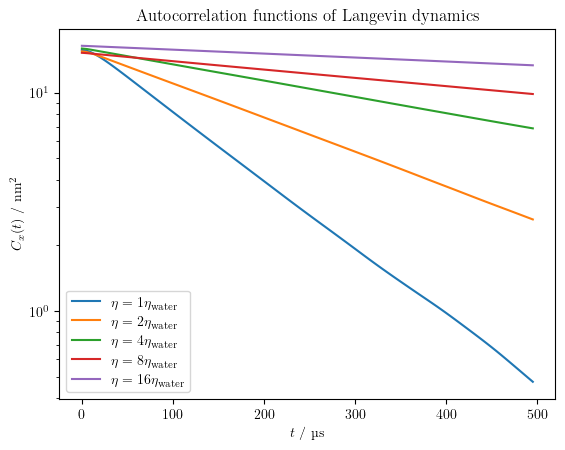

In [ ]:
acf_step=5;
acf_maxstep=500;
for ii in range(0,5):
    positions_here = (langevin_results[ii]["positions"] - np.mean(langevin_results[ii]["positions"]))/1e-9;
    plt.plot(times[range(0,acf_maxstep,acf_step)]/1e-6,[np.mean(positions_here[i:len(positions_here)] * positions_here[0:(len(positions_here)-i)]) for i in range(0,acf_maxstep,acf_step)],label="$\eta="+str(viscosity_multipliers[ii])+"\eta_{\mathrm{water}}$")
plt.yscale("log");
plt.xlabel("$t$ / µs")
plt.ylabel("$C_x(t)$ / $\mathrm{nm}^2$")
plt.title("Autocorrelation functions of Langevin dynamics")
plt.legend();
plt.savefig("Langevin_vs_viscosity_ACF.png",dpi=300)
plt.show()

/var/folders/f0/016fff6d3372w9zb168899lr0000gn/T/ipykernel_90368/1013717215.py:22: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show();


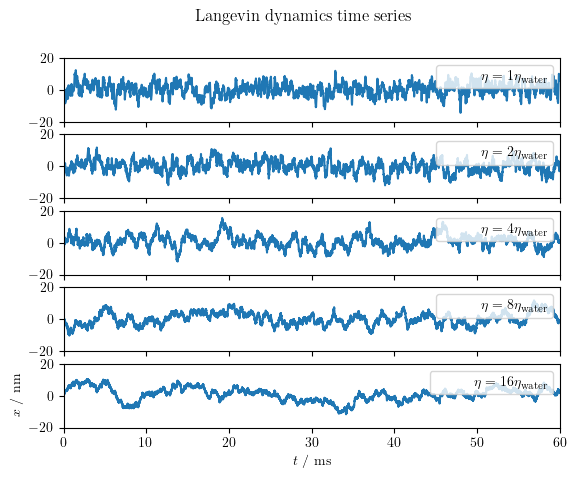

In [ ]:
fig, axs = plt.subplots(5);
fig.suptitle("Langevin dynamics time series");
for i in range(0,4,1):
    axs[i].plot(langevin_results[i]["times"][1:100_000:1]/1e-3,(langevin_results[i]["positions"][1:100_000:1]-np.mean(langevin_results[i]["positions"]))/1e-9);
    axs[i].tick_params(labelbottom=False);
    axs[i].plot([],[],' ',label="$\eta = "+str(viscosity_multipliers[i])+"\eta_{\mathrm{water}}$");
    axs[i].set_xlim(0,60);
    axs[i].set_ylim(-20,20);
    axs[i].legend(loc="upper right");


axs[4].plot(langevin_results[4]["times"][1:100_000:1]/1e-3,(langevin_results[4]["positions"][1:100_000:1]-np.mean(langevin_results[4]["positions"]))/1e-9);
axs[4].plot([],[],' ',label="$\eta = "+str(viscosity_multipliers[4])+"\eta_{\mathrm{water}}$");
axs[4].set_xlim(0,60);
axs[4].set_ylim(-20,20);
axs[4].set_ylabel("$x$ / nm");
axs[4].set_xlabel("$t$ / ms");
axs[4].legend(loc="upper right");


fig.savefig("Langevin_vs_viscosity_time_series.png",dpi=300)
fig.show();